<p style="font-size:25pt; font-weight:bold">A/B TEST</p>

# Description

We want to perform AB test. We test customer conversion rates in two groups A and B (without and with block of reccomendations on our website)

Task:
1. Plan a test
 - Calc sample sizes
2. Load results of the test
3. Evaluate results
 - calc p-values, power of test
4. Make a decision<br>
    options are: 
    1. stop the test. One of groups has won.
    2. stop the test, there was no effect.
    3. proceed the test.

# A priori

We expect to achieve conversion growth from 2.3% to 2.8%

**Task:**<br>
Compute required samples sizes for required effect with acceptable 1st and 2nd type errors
- $\alpha$ (I-type error, false reject $H_{0}$), 
- $\beta$ (II-type error, false accept $H_0$, 1-power)

We set alpha = 5% and beta=10%

In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


import scipy.stats as stats
import statsmodels.stats.proportion as sms
from scipy.stats import norm

In [20]:
significance = 0.05

In [21]:
'''
sms.samplesize_proportions_2indep_onetail(diff, prop2, power, ratio=1, alpha=0.05, alternative='two-sided')
p1 = p2 + diff
nobs2 = ratio * nobs1
Significance level, e.g. 0.05, is the probability of a type I error, that is wrong 
rejections if the Null Hypothesis is true
Power of the test, e.g. 0.8, is one minus the probability of a type II error. 
Power is the probability that the test correctly rejects the null hypothesis if the alternative hypothesis is true.
'''
sample_size_n1 = sms.samplesize_proportions_2indep_onetail(
    diff=-0.005, 
    prop2=0.028, 
    power=0.9, 
    ratio=1, 
    alpha=0.05, 
    alternative='greater'
)
sample_size_n2 = 1 * sample_size_n1

print(f'Required sample sizes:\n  n1 = {int(np.ceil(sample_size_n1))}\n  n2 = {int(np.ceil(sample_size_n2))}')

Required sample sizes:
  n1 = 17023
  n2 = 17023


# EXPERIMENT

## ETL

In [22]:
def hist_and_boxplot(data, col, iqr=3, figsize=(16, 8)):
    '''
    plot histplot with boxplot for data overall view
    :param data: pandas DataFrame
    :param col: name of column with data to evaluate
    :param iqr: koefficient in IQR approach to detect fliers (UBound = Q75 + iqr * (Q75-Q25))
    :param figsize: touple
    :return: fliers
    '''
    fig, ax = plt.subplots(figsize=figsize , nrows=2,ncols=1, sharex=True, gridspec_kw={'height_ratios': [10, 1.5]})
    fig.suptitle(col, fontsize=16)
    # fig.set_size_inches(12, 8)
    data[col].hist(bins=80, ax=ax[0])
    
    stat = data[col].describe()

    b = data.boxplot(column=col, widths=0.5, vert=False, showcaps=True, whis=iqr, ax=ax[1], 
                     flierprops={'marker': '|', 'markersize': 15, 'markeredgecolor': 'g', 'markeredgewidth':2, 'zorder':1},
                     capprops={'color':'r', "linewidth": 2, 'zorder':3}, return_type='dict')
    ax[1].set_yticklabels([''])
    ax[1].grid(visible=False, axis='both')
    fliers = b['fliers'][0].get_xdata()
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.text(
        0.047,
        0.915,
        f"count: {stat['count']:,.0f} \
    fliers: {fliers.shape[0]} ({sum(fliers<stat['50%'])}, {sum(fliers>stat['50%'])}) \
    median: {b['medians'][0].get_xdata()[0]} \
    mean: {stat['mean']:.1f} \
    caps: [{b['caps'][0].get_xdata()[0]}, {b['caps'][1].get_xdata()[0]}] \
    box: [{b['boxes'][0].get_xdata()[0]}, {b['boxes'][0].get_xdata()[2]}] \
    min max: [{stat['min']:.1f}, {stat['max']:.1f}]",
        ha="left",
#             color='w',
        fontname="DejaVu Sans",
        fontsize=12,
        )
    plt.show()
    return fliers

In [23]:
def sub_hist_and_boxplot(df, col, subfig, iqr=3, seaborn_hist=True):
    '''
    accessory plot  for plotting axes on subfigure
    :param df: DataFrame
    :param col: column name for plotting
    :param subfig: object Figure
    '''
    subfig.suptitle(col, fontsize=12)
    
    
    if df[col].dtype in [np.dtype('float64'), np.dtype('int64')]:
        ax = subfig.subplots(nrows=2,ncols=1, sharex=True, gridspec_kw={'height_ratios': [10, 1.5]})
        if not seaborn_hist:
            df.hist(column=col, bins=80, ax=ax[0])
        else:
            sns.histplot(data=df, x=col, ax=ax[0])
        b = df.boxplot(column=col, widths=0.5, vert=False, showcaps=True, whis=iqr, ax=ax[1],  
                       flierprops={'marker': '|', 'markersize': 15, 'markeredgecolor': 'g', 'markeredgewidth':2, 'zorder':1},
                       capprops={'color':'r', "linewidth": 2, 'zorder':3}, return_type='dict')
        ax[1].set_yticklabels([])
        ax[1].grid(visible=False, axis='both')
        ax[0].grid(visible=True, axis='y')
        
    if df[col].dtype == np.dtype('<M8[ns]'):
        ax = subfig.subplots(nrows=1,ncols=1)
        if not seaborn_hist:
            df.hist(column=col, bins=80)
        else:
            sns.histplot(data=df, x=col)
        ax.grid(visible=True, axis='y')
        ax.tick_params(axis='x', labelrotation=30)
        
    elif df[col].dtype == np.dtype('O'):
        ax = subfig.subplots(nrows=1,ncols=1)
        s = df[col].value_counts()
        if s[15:].sum() >0:
            t = pd.concat([s[:15], pd.Series(index=['_other_'], data=[s[15:].sum()])]).reset_index()
        else:
            t = s.copy().reset_index()
        t.columns = ['cat_name', 'count']
        ax.pie(t['count'], labels=t['cat_name'], autopct='%1.1f%%');

    
    
    
    
    return subfig, ax

In [24]:
def corr_triag_heatmap(corr, title_str):
    '''
    Function to draw triangle heatmap matrix (without diagonal elements)
    :param corr: correlation table
    :param title_str: plot title string
    '''

    
    # mask = np.zeros_like(corr)
    # mask[np.triu_indices_from(mask)] = True
    mask = np.triu(np.full(corr.shape, True))
    corr = corr.iloc[1:, :-1]
    mask = pd.DataFrame(mask).iloc[1:, :-1].to_numpy()

    # делаем heatmap
    plt.figure(figsize=(corr.shape[0] * 1.2, (corr.shape[0] * 0.6)))
    ax = sns.heatmap(corr, annot=True, cmap="RdBu", mask=mask, vmin=-1, vmax=1)
    ax.set_title(title_str, fontdict={'fontsize':14})
    plt.show()

def evaluate_df(df, title="", show_corr_zero_plots = False, show_corr_null_plots=False, show_scatter_matrix=False, show_histograms=False, show_histograms_box=True):
    '''
    Function for dataframe evaluation
      1) show sample
      2) show data types in columns
      3) show count NaN and zeros
      4) correlation zeros at the same objects in different columns
      5) correlation NaNs at the same objects in different columns
      6) scatter_matrix
    :param df: pandas DataFrame
    :param show_corr_zero_plots: 
    :param show_corr_null_plots: 
    :param show_scatter_matrix: 
    '''
    print(''.ljust(96, '-'))
    s='---   ' + title + '   '
    print(s.ljust(96, '-'))
    print(''.ljust(96, '-'))
    
    print('\nComplete duplicates:', df.duplicated().sum())
    print('Empty cells:', df.isna().sum().sum())
    
    
    print('\n------SAMPLE--------')
    display(df.sample(min(5,len(df))))
    print('\n------DTYPES--------')
    print(df.dtypes)

    # count NaN
    print('\n\n------NaN & zero--------')
    na = pd.DataFrame(index=df.columns
                      , data={
                          'NA':df.isna().sum().values
                          , 'filled': df.notna().sum().values
                          , 'zero':df.eq(0).sum()
                      }
                     )
    na['%na'] = na['NA']/len(df)*100
    print(na.replace(0,'-'))
    
    
    
    if show_corr_zero_plots:
        # correlation matrix of zeros
        t = df.eq(0).sum().sort_values()
        indx = t[t > 0].index
        if len(indx) > 1:
            print()
            corr = df[indx].isin([0,'0']).corr()
            corr_triag_heatmap(corr, "Correlation of ZEROs in columns")
            
            # Add map of zeros
            t = df[indx].eq(0).sort_values(by=list(indx))
            plt.figure(figsize = (20,len(indx)*0.6))
            
            ax = sns.heatmap(t.transpose(), alpha=0.4,cbar_kws = {"ticks":[False, True], "drawedges":True}, cmap=sns.color_palette(['#00AA00', '#FF4444']))
            ax.set_title("Map of ZEROs values", fontdict={'fontsize':14})
            ax.hlines(ax.yaxis.get_ticklocs() + 0.5, 0, t.shape[0], color='w', linewidths=1)
            plt.show()
    if show_corr_null_plots:
        # correlation matrix of NaN
        t = df.isna().sum().sort_values()
        indx = t[t > 0].index
        if len(indx) > 1:
            print()
            corr = df[indx].isna().corr()
            corr_triag_heatmap(corr, "Correlation of NULL in columns")
            
            # Add map of NaN
            t = df[indx].isna().sort_values(by=list(indx))
            plt.figure(figsize = (20,len(indx)*0.6))
            
            ax = sns.heatmap(t.transpose(), alpha=0.4,cbar_kws = {"ticks":[False, True], "drawedges":True}, cmap=sns.color_palette(['#00AA00', '#FF4444']))
            ax.set_title("Map of NULL values", fontdict={'fontsize':14})
            ax.hlines(ax.yaxis.get_ticklocs() + 0.5, 0, t.shape[0], color='w', linewidths=1)
            plt.show()

#     display(df.describe(include='all').transpose())
    print('\n\n------ describe --------')
    if np.dtype('int64') in df.dtypes.values or np.dtype('float64') in df.dtypes.values:
        print('\n\tNumeric')
        display(df.describe(include=[np.number]).transpose())
    if np.dtype('<M8[ns]') in df.dtypes.values:
        print('\n\tDateTime')
        display(df.describe(include=['datetime'], datetime_is_numeric=True).transpose())
    
#     print('\n\tCategory')
#     display(df.describe(include=['category']).transpose())
    
    if np.dtype('O') in df.dtypes.values:
        print("\n\tText (object)")
        df_o = df.describe(include=[object]).transpose()
        display(df_o)
        for col in df_o.index:
            uniq_cnt = df_o.loc[col, "unique"]
            print("\n  Unique:", uniq_cnt)
            if 15<uniq_cnt < 300:
                print(f'\n{col} unique: {uniq_cnt}\n', df[col].sort_values().unique())
            s = df['group'].value_counts()
            display(pd.concat([s[:15], pd.Series(index=['_other_'], data=[s[15:].sum()])]))
            
    
    if show_scatter_matrix:
        pd.plotting.scatter_matrix(df, figsize=(16,10), alpha=0.1, s=5);
    
    if show_histograms:
        cols_no = 4
        rows_no = (len(df.columns) - 1)//cols_no +1 # number rows

        # plot hostograms for numeric features and pie charts for categorial
        fig, ax = plt.subplots(nrows=rows_no, ncols=cols_no, layout="constrained", squeeze = False)
        fig.set_figheight(3 * rows_no)
        fig.set_figwidth(4 * cols_no)

        for i in range(len(df.columns)):
            r = i // cols_no
            c = i - r * cols_no
            col = df.columns[r*cols_no + c]
            if df[col].dtype in [np.dtype('float64'), np.dtype('int64'), np.dtype('<M8[ns]')]:
                ax[r,c].hist(df[col])
                ax[r,c].set_title(col)
                if df[col].dtype == np.dtype('<M8[ns]'):
                    ax[r,c].tick_params(axis='x', labelrotation=30)
            elif df[col].dtype == np.dtype('O'):
                t = df[col].value_counts().reset_index()
                t.columns = ['cat_name', 'count']
                ax[r,c].pie(t['count'], labels=t['cat_name'], autopct='%1.1f%%');
                ax[r,c].set_title(col)

        if c != cols_no:
            for c_ in range(c+1, cols_no, 1):
                ax[r,c_].axis('off')
        plt.show()
    if show_histograms_box:
        list_col = df.columns
        cols_no = 2
        rows_no = (len(list_col) - 1)//cols_no +1 # number rows

        fig = plt.figure(constrained_layout=True, figsize=(4*cols_no,rows_no*3))
        fig.suptitle('Гистограммы переменных', fontsize=16)
        subfigs = fig.subfigures(rows_no, cols_no)


        for outerind, subfig in enumerate(subfigs.flat):
            if outerind < len(list_col):
                col = list_col[outerind]
                sub_hist_and_boxplot(df, col, subfig)

        plt.show()

### Load data

In [25]:
df_orders = pd.read_csv('datasets/orders.csv', parse_dates=[2])
df_visitors = pd.read_csv('datasets/visitors.csv', parse_dates=[0])

------------------------------------------------------------------------------------------------
---   Orders   ---------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------

Complete duplicates: 0
Empty cells: 0

------SAMPLE--------


,transactionId,visitorId,date,revenue,group
1041,3497987294,1212176445,2019-08-11,1780,A
17,1108180333,222718357,2019-08-15,990,B
886,51443164,4278982564,2019-08-05,24744,A
1082,2055901696,2944179391,2019-08-12,6015,B
653,2107411712,2819363575,2019-08-07,1530,B



------DTYPES--------
transactionId             int64
visitorId                 int64
date             datetime64[ns]
revenue                   int64
group                    object
dtype: object


------NaN & zero--------
              NA  filled zero %na
transactionId  -    1197    -   -
visitorId      -    1197    -   -
date           -    1197    -   -
revenue        -    1197    -   -
group          -    1197    -   -


------ describe --------

	Numeric


,count,mean,std,min,25%,50%,75%,max
transactionId,1197.0,2.155621e+09,1.229085e+09,1062393.0,1.166776e+09,2.145194e+09,3.237740e+09,4.293856e+09
visitorId,1197.0,2.165960e+09,1.236014e+09,5114589.0,1.111826e+09,2.217985e+09,3.177606e+09,4.283872e+09
revenue,1197.0,8.348006e+03,3.919113e+04,50.0,1.220000e+03,2.978000e+03,8.290000e+03,1.294500e+06



	DateTime


,count,mean,min,25%,50%,75%,max
date,1197,2019-08-15 13:06:46.015037696,2019-08-01,2019-08-08,2019-08-15,2019-08-23,2019-08-31



	Text (object)


,count,unique,top,freq
group,1197,2,B,640



  Unique: 2


B          640
A          557
_other_      0
dtype: int64

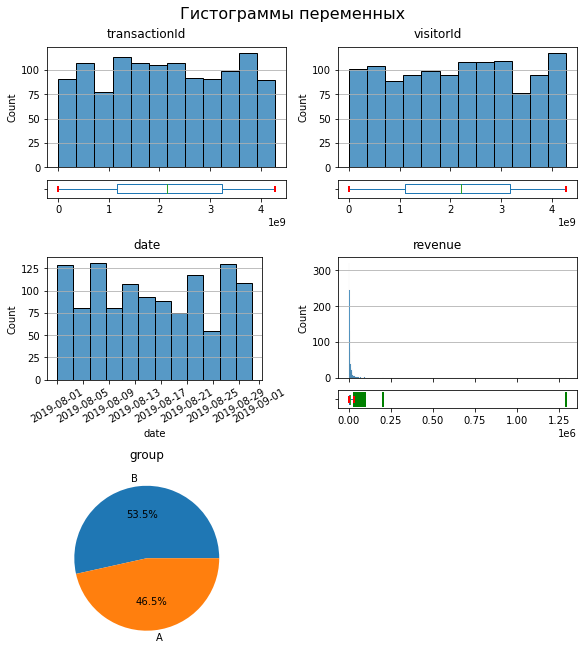

In [26]:
evaluate_df(df_orders, title="Orders")

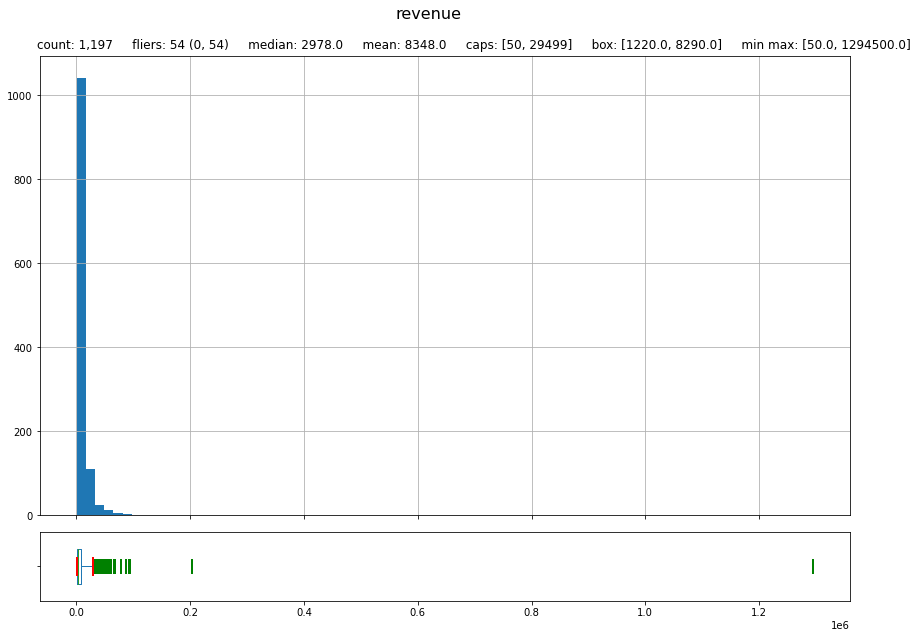

In [27]:
hist_and_boxplot(df_orders, 'revenue', figsize=(12,9), iqr=3);


------------------------------------------------------------------------------------------------
---   Visitors   -------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------

Complete duplicates: 0
Empty cells: 0

------SAMPLE--------


,date,group,visitors
0,2019-08-01,A,719
45,2019-08-15,B,544
48,2019-08-18,B,737
12,2019-08-13,A,748
19,2019-08-20,A,575



------DTYPES--------
date        datetime64[ns]
group               object
visitors             int64
dtype: object


------NaN & zero--------
         NA  filled zero %na
date      -      62    -   -
group     -      62    -   -
visitors  -      62    -   -


------ describe --------

	Numeric


,count,mean,std,min,25%,50%,75%,max
visitors,62.0,607.290323,114.40056,361.0,534.0,624.5,710.5,770.0



	DateTime


,count,mean,min,25%,50%,75%,max
date,62,2019-08-16,2019-08-01,2019-08-08 06:00:00,2019-08-16,2019-08-23 18:00:00,2019-08-31



	Text (object)


,count,unique,top,freq
group,62,2,A,31



  Unique: 2


A          31
B          31
_other_     0
dtype: int64

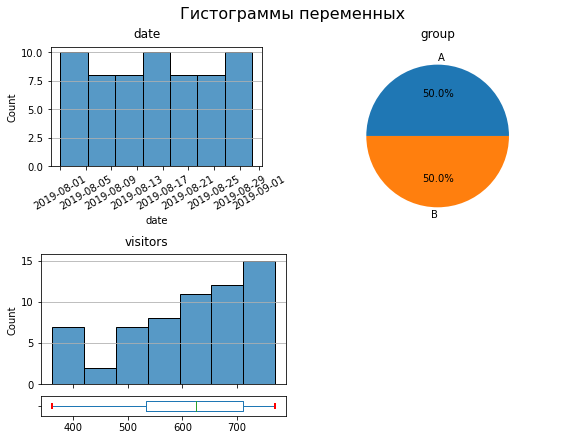

In [28]:
evaluate_df(df_visitors, title="Visitors")

#### transactionId duplicates

In [29]:
df_orders['transactionId'].duplicated().sum()

0

#### check a rule "One client - One group"

In [30]:
t = df_orders[['visitorId', 'group']].drop_duplicates().groupby(by=['visitorId'])['group'].count()
t.value_counts()

1    973
2     58
Name: group, dtype: int64

**ERROR FOUND:** There was 58 clients with orders in both groups "A" and "B". The test was incorrect. We must eliminate theese clients.

create lists of correct clients and incorrect

In [31]:
correct_clients_id = t[t==1].index
incorrect_clients_id = t[t==2].index

We have to delete incorrect clients from orders and their visits from df_visitors

In [32]:
orders_agg = df_orders.groupby(by=['date', 'group'])['visitorId'].count().reset_index()
orders_agg.rename(columns={'visitorId':'orders'}, inplace=True)
orders_agg.head()

,date,group,orders
0,2019-08-01,A,24
1,2019-08-01,B,21
2,2019-08-02,A,20
3,2019-08-02,B,24
4,2019-08-03,A,24


In [33]:
incorrect_orders_agg = df_orders.query('visitorId in @incorrect_clients_id').groupby(by=['date', 'group'])['visitorId'].count().reset_index()
incorrect_orders_agg.rename(columns={'visitorId':'incorrect_count'}, inplace=True)
incorrect_orders_agg.head()

,date,group,incorrect_count
0,2019-08-01,A,1
1,2019-08-01,B,4
2,2019-08-02,A,1
3,2019-08-02,B,1
4,2019-08-03,B,2


Prepare corrected orders and visits by days for each group

#### if the dates in df_visitors are the same as in df_orders

In [34]:
set(df_visitors['date'].drop_duplicates()) == set(df_orders['date'].drop_duplicates())

True

### Transform

In [35]:
df_total = df_visitors \
    .merge(orders_agg, on=['date', 'group'], how='left') \
    .merge(incorrect_orders_agg, on=['date', 'group'], how='left') \
    .fillna(0)
df = df_total.copy()
df['visit_c'] = df_total['visitors'] - df_total['incorrect_count']
df['order_c'] = df_total['orders'] - df_total['incorrect_count']
df.drop(labels=['visitors', 'orders', 'incorrect_count'], axis=1, inplace=True)
df.head()

,date,group,visit_c,order_c
0,2019-08-01,A,718.0,23.0
1,2019-08-02,A,618.0,19.0
2,2019-08-03,A,507.0,24.0
3,2019-08-04,A,712.0,11.0
4,2019-08-05,A,753.0,22.0


**CONCLUSIONS**

- data sets are correct
 - no duplicates
 - no NaN
 - groups are balanced
 - dates in ordares and visitors are from the same range

There was some outliers in revenue. But revenue doesnt interesting for us


The test was incorrect. Some visitors were in both groups "A" and "B". We eliminate incorrect orders from odrers and visits

## EDA

### correlation  date visits orders

Lets see the correlation table [date, visit_c, order_c]

In [36]:
np.corrcoef([pd.to_numeric(df['date']), df['visit_c'], df['order_c']])

array([[ 1.        , -0.16719553, -0.25194448],
       [-0.16719553,  1.        , -0.02686075],
       [-0.25194448, -0.02686075,  1.        ]])

No significant correlations. Check correlations for groups A and B

In [37]:
np.corrcoef([pd.to_numeric(df.query('group == "A"')['date']), df.query('group == "A"')['visit_c'], df.query('group == "A"')['order_c']])

array([[ 1.        , -0.19629499, -0.30651939],
       [-0.19629499,  1.        ,  0.08455608],
       [-0.30651939,  0.08455608,  1.        ]])

In [38]:
np.corrcoef([pd.to_numeric(df.query('group == "B"')['date']), df.query('group == "B"')['visit_c'], df.query('group == "B"')['order_c']])

array([[ 1.        , -0.13968267, -0.21285857],
       [-0.13968267,  1.        , -0.15640713],
       [-0.21285857, -0.15640713,  1.        ]])

Again no correlations. Look at scatterplots

Check if count of orders depend on date

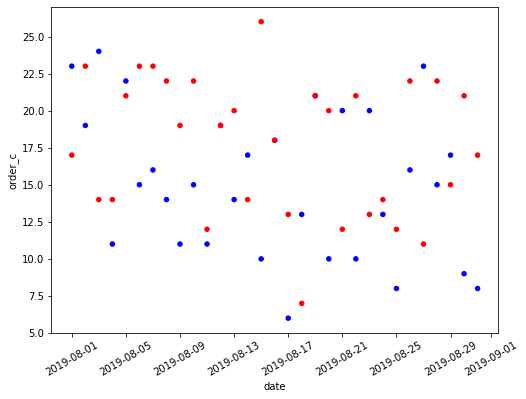

In [39]:
ax = df.plot.scatter(y='order_c', x='date', figsize=(8,6), c=df['group'].map({"A": "blue", "B": "red"}))
ax.tick_params(axis='x', labelrotation=30)

There is no trend, no collelation, no outliers

Check if count of visits depend on date

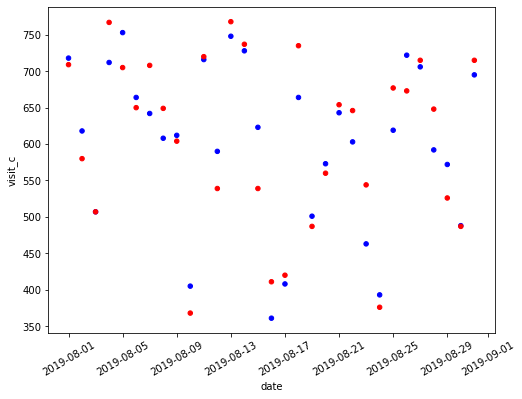

In [40]:
ax = df.plot.scatter(y='visit_c', x='date', figsize=(8,6), c=df['group'].map({"A": "blue", "B": "red"}))
ax.tick_params(axis='x', labelrotation=30)

There is no trend, no collelation, no outliers

Check if count of visits depend on count of orders

<AxesSubplot:xlabel='visit_c', ylabel='order_c'>

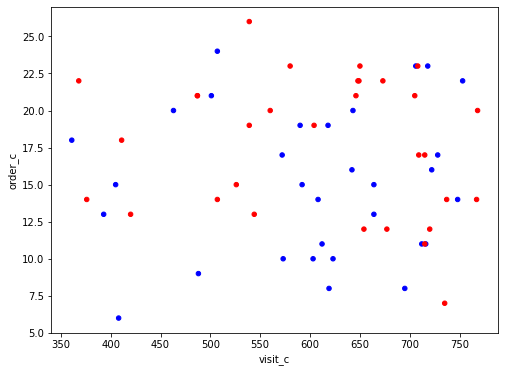

In [41]:
df.plot.scatter(x='visit_c', y='order_c', figsize=(8,6), c=df['group'].map({"A": "blue", "B": "red"}) )

There is no trend, no collelation, no outliers

**NOTE**  this is very strange, count of orders does not depend on count of visits

### conversions

In [49]:
conversion = df.pivot_table(index='date', columns='group', values=['visit_c', 'order_c'], aggfunc='sum')
conversion.columns = ['A_o', 'B_o', 'A_v', 'B_v']
conversion['A'] = conversion['A_o'] / conversion['A_v']
conversion['B'] = conversion['B_o'] / conversion['B_v']
# conversion.drop(labels=['A_o', 'B_o', 'A_v', 'B_v'], axis=1, inplace=True)
conversion.head()

,A_o,B_o,A_v,B_v,A,B
date,,,,,,
2019-08-01,23.0,17.0,718.0,709.0,0.032033,0.023977
2019-08-02,19.0,23.0,618.0,580.0,0.030744,0.039655
2019-08-03,24.0,14.0,507.0,507.0,0.047337,0.027613
2019-08-04,11.0,14.0,712.0,767.0,0.015449,0.018253
2019-08-05,22.0,21.0,753.0,705.0,0.029216,0.029787


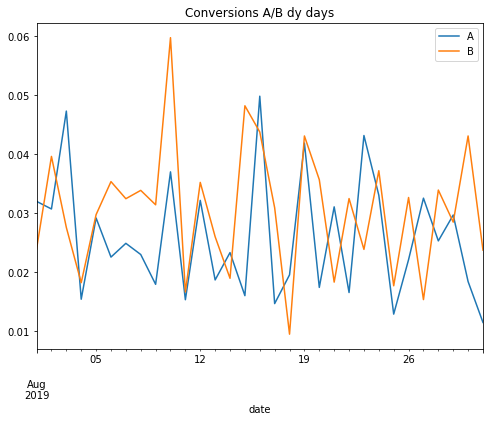

In [62]:
conversion[['A', 'B']].plot(figsize=(8,6), title="Conversions A/B dy days");

Conversions rates on last half period almost the same.<br> 
Conversions rates on first half looks different. 

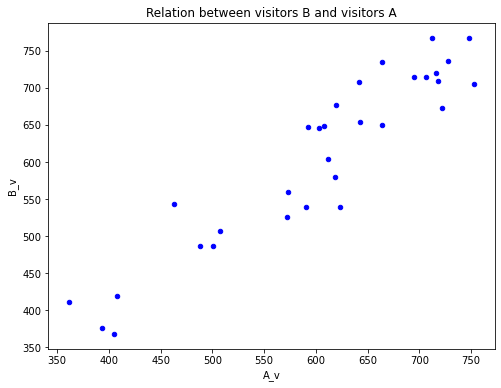

In [68]:
ax = conversion.plot.scatter(x='A_v', y='B_v', figsize=(8,6), c="blue", title="Relation between visitors B and visitors A")
# conversion.plot.scatter(x='B_o', y='B', figsize=(8,6), c="red", ax=ax)

This is what we expected. Visitors by days are correlated in groups A/B

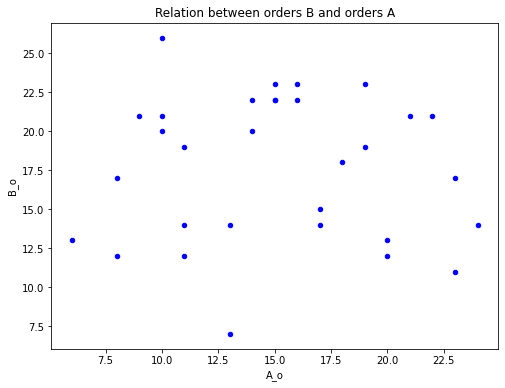

In [67]:
ax = conversion.plot.scatter(x='A_o', y='B_o', figsize=(8,6), c="blue", title="Relation between orders B and orders A")
# conversion.plot.scatter(x='B_o', y='B', figsize=(8,6), c="red", ax=ax)

This is unexpected. Orders by days are not correlated in groups A/B

**CONCLUSIONS**

- visits A and B have hight correlation, however orders A and B are not related in any way
- orders are not corelated with visits(!!!)
- conversions during first hald period looks different with last half period. Need to test(!!!)

<font color="red">**Theese are very anxious conclusions. Our model of random Bernulli process is called into question now.**</p>

# Post hoc

In [44]:
def test_contingency_table(test_results, id_alternative=0):
    '''
    Function to test results AB test
    :param test_results: Pandas DataFrame 
        total_A  success_A
        total_B   success_B
    :param id_alternative: set id from list kinds alternative ['two-sided', 'less', 'greater']
    '''
    display(test_results)

    n1 = test_results.values[0][0]
    n2 = test_results.values[1][0]
    k1 = test_results.values[0][1]
    k2 = test_results.values[1][1]

    p1 = k1/n1
    p2 = k2/n2

    print('Conversion rates:')
    print('  A:', p1)
    print('  B:', p2)


    contingency_table = [[n1-k1, k1], [n2-k2, k2]]
    print('\ncontingency table\n', contingency_table)
    
    alternative_dict = [['two-sided', 'less', 'greater'], ['two-sided', 'smaller', 'larger']]
    
    print('\n\nalternative:' , alternative_dict[0][id_alternative])

    print(''.ljust(96, '-'))
    print(' ' * 4 + 'EXACT Fisher test')
    print(''.ljust(96, '-'))

    # fisher_exact
    oddsratio, pvalue = stats.fisher_exact(contingency_table, alternative=alternative_dict[0][id_alternative]) # 'two-sided', 'less', 'greater'
    print(f'\tp-value: {pvalue:.7f} and oddsratio: {oddsratio:.4f}\n')
    inv_id_alternative = id_alternative
    if inv_id_alternative == 2:
        inv_id_alternative = 1
    elif inv_id_alternative == 1:
        inv_id_alternative = 2
    print('\tpower:', 
          sms.power_proportions_2indep(
            diff=p1-p2, 
            prop2=p2, 
            nobs1=n1, 
            ratio=n2/n1, 
            alpha=significance, 
            alternative=alternative_dict[1][inv_id_alternative], 
            return_results=False
          )
         )
    if significance > pvalue:   
        print('\tH0-hypotesis of equality of probability of success in two populations is REJECTED.\n\tH1-hypotesis about difference is ACCEPTED')
    else:
        print('\tH0-hypotesis of equality of probability of success in two populations COULD NOT BE rejected.')




    print('\n\n'.ljust(96, '-'))
    print(' ' * 4 + 'APPROXIMATE normality')
    print(''.ljust(96, '-'))
    print(' ' * 6 + 'Z-test')    

    # from statsmodels.stats.proportion import proportions_ztest, proportion_confint


    # Рассчитываем pvalue и Z статистику chi2 
    z_stat, pval = sms.proportions_ztest(count=[k2, k1], nobs=[n2, n1], value=0, alternative=alternative_dict[1][id_alternative]) # 'two-sided', 'smaller', 'larger'

    # Рассчитываем доверительные интервалы для среднего у выборок 
    (lower_2, lower_1), (upper_2, upper_1) = sms.proportion_confint(count=[k2, k1], nobs=[n2, n1], alpha=0.05) 


    print(f'\tp-value: {pval:.7f} and z statistic: {z_stat:.4f}\n')
    
    p= (n1*p1 + n2*p2)/(n1+n2)
    # Z statistic
    z = (p2-p1)/np.sqrt(p*(1-p)*(1/n1+ 1/n2))

    std_  =np.sqrt(p*(1-p)*(1/n1+ 1/n2))
    x_ = (p2-p1)

    t = norm.ppf(1-significance, loc=0, scale=std_)
    print('\tpower:', 1-norm.cdf(t, loc=x_, scale=std_))
    
    print(f'\n\tci 95% for group B: [{lower_2:.3f}, {upper_2:.3f}]') 
    print(f'\tci 95% for group A: [{lower_1:.3f}, {upper_1:.3f}]')
    
    if significance > pval:   
        print('\tH0-hypotesis of equality of probability of success in two populations is REJECTED.\n\tH1-hypotesis about difference is ACCEPTED')
    else:
        print('\tH0-hypotesis of equality of probability of success in two populations COULD NOT BE rejected.')

## Test that true odds ratios are equal

We suppose that in each group there is a probability that visitor become a client (we call such probability in limited group as conversion rate)
Such process generated by Bernulli process

Test hypotesis:
* H0: probability of success in 1st population is the same as probability of success in 2nd population
* H1: probability of success in 2nd population is greater than probability of success in 1st population

Exact test is **stats.fisher_exact**. But its computational difficult, and in cases with big samples (we have more than 16000 in each group) useful assumption of normality (due to central limit teorem). Useful **proportions_ztest**


In [45]:
# first half period
test_contingency_table(
    test_results=df.query('date < "2019-08-16"').groupby(by=['group'])[['visit_c', 'order_c']].sum(),
    id_alternative=2
)

,visit_c,order_c
group,,
A,9644.0,241.0
B,9550.0,289.0


Conversion rates:
  A: 0.024989630858564912
  B: 0.030261780104712043

contingency table
 [[9403.0, 241.0], [9261.0, 289.0]]


alternative: greater
------------------------------------------------------------------------------------------------
    EXACT Fisher test
------------------------------------------------------------------------------------------------
	p-value: 0.0144200 and oddsratio: 1.2176

	power: 0.720289602506761
	H0-hypotesis of equality of probability of success in two populations is REJECTED.
	H1-hypotesis about difference is ACCEPTED


----------------------------------------------------------------------------------------------
    APPROXIMATE normality
------------------------------------------------------------------------------------------------
      Z-test
	p-value: 0.0129154 and z statistic: 2.2287

	power: 0.7203533844588916

	ci 95% for group B: [0.027, 0.034]
	ci 95% for group A: [0.022, 0.028]
	H0-hypotesis of equality of probability of success in two pop

In [46]:
test_contingency_table(
    test_results=df.query('date >= "2019-08-16"').groupby(by=['group'])[['visit_c', 'order_c']].sum(),
    id_alternative=2
)

,visit_c,order_c
group,,
A,9003.0,227.0
B,9274.0,259.0


Conversion rates:
  A: 0.025213817616350106
  B: 0.02792753935734311

contingency table
 [[8776.0, 227.0], [9015.0, 259.0]]


alternative: greater
------------------------------------------------------------------------------------------------
    EXACT Fisher test
------------------------------------------------------------------------------------------------
	p-value: 0.1369440 and oddsratio: 1.1107

	power: 0.3067139675436523
	H0-hypotesis of equality of probability of success in two populations COULD NOT BE rejected.


----------------------------------------------------------------------------------------------
    APPROXIMATE normality
------------------------------------------------------------------------------------------------
      Z-test
	p-value: 0.1271312 and z statistic: 1.1401

	power: 0.30685089863684467

	ci 95% for group B: [0.025, 0.031]
	ci 95% for group A: [0.022, 0.028]
	H0-hypotesis of equality of probability of success in two populations COULD NOT BE rejected.


In [47]:
test_contingency_table(
    test_results=df.groupby(by=['group'])[['visit_c', 'order_c']].sum(),
    id_alternative=2
)

,visit_c,order_c
group,,
A,18647.0,468.0
B,18824.0,548.0


Conversion rates:
  A: 0.0250978709712018
  B: 0.029111772205694858

contingency table
 [[18179.0, 468.0], [18276.0, 548.0]]


alternative: greater
------------------------------------------------------------------------------------------------
    EXACT Fisher test
------------------------------------------------------------------------------------------------
	p-value: 0.0091084 and oddsratio: 1.1647

	power: 0.7725866536560142
	H0-hypotesis of equality of probability of success in two populations is REJECTED.
	H1-hypotesis about difference is ACCEPTED


----------------------------------------------------------------------------------------------
    APPROXIMATE normality
------------------------------------------------------------------------------------------------
      Z-test
	p-value: 0.0083799 and z statistic: 2.3919

	power: 0.7724927573692055

	ci 95% for group B: [0.027, 0.032]
	ci 95% for group A: [0.023, 0.027]
	H0-hypotesis of equality of probability of success in two po

**CONCLUSION**<br>
We achieve strong opposite results on theese first and last periods.
First and lash halfs of period statistically significant different.

Howewer we chould notice, power is VERY low on last half of period.<BR>Test could make II-type error (do not reject Ho when H1 is True)
    
    Results are not clear


# SUMMARY

We plan and evaluate the AB test.
- Collected data was technically correct (no duplicates, no empties, groups are balanced, correct dates)
- There was some outliers in revenue. But revenue doesnt interesting for the test

Some issues arise:
- 58 visitors were in both groups "A" and "B". We eliminate incorrect orders from odrers and visits
- orders are not corelated with visits. We unable to fix this. We should consider case our model (there is some probability of success to visitor to make an order) is not represent reality and orders depend on other sales channel. 

We achieve strong opposite statistically significant results on the first and last half periods.
- on first half there was an effect and we reject null-hypotesis with low level I-type error = 1.4% and medium (acceptable) II-type error = 28% 
- on last half there wasn't an effect and we couldn't reject null-hypotesis. With hight I-type error = 13.7% and hight II-type error = 70%. Test could make II-type error (do not reject Ho when H1 is True)

**RECOMMENDATIONS:**

1. Fix users in both groups
2. Explain why orders are not correlated with visits
3. Proceed test at least 2 weeks to eliminate doubts and concerns